In [2]:
import os
import numpy as np
import seaborn as sns
# add the path of the parent directory to the path
import sys

sys.path.append('../')
import visualize_simulations as viz
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
from estimates.elongation import estElong, find_gap
import helper
import pandas as pd 
ONE_KB=1000
SIM_FEAT_LEN = 5000 # length of one feature in the simulation
SEED = 9999
np.random.seed(SEED)

Using cuda device


In [3]:
import pandas as pd
import numpy as np
gene_name = 'ENSG00000003989'
fn1 = f'/gladstone/engelhardt/lab/hvu/RNA_rates/data_from_jesse/{gene_name}/{gene_name}_nt_coverage_0-5.bed'
fn2 = f'/gladstone/engelhardt/lab/hvu/RNA_rates/data_from_jesse/{gene_name}/{gene_name}_nt_coverage_5-10.bed'
fn3 = f'/gladstone/engelhardt/lab/hvu/RNA_rates/data_from_jesse/{gene_name}/{gene_name}_nt_coverage_10-15.bed'

def read_one_file(fn, timepoint=None):
    df = pd.read_csv(fn, sep='\t', header=None)
    df.columns = ['chrom', 'start', 'end', 'gene', 'dot', 'strand', 'coord', 'coverage']
    if timepoint is not None:
        df.rename(columns={'coverage':  timepoint}, inplace=True)
    return df

def merge_dfs(df_list):
    '''
    Given all the df, merge them by the coord column
    :param df_list: 
    :return: 
    '''
    df = df_list[0]
    for i in range(1, len(df_list)):
        df = pd.merge(df, df_list[i][['coord', i]], on='coord', how='outer')
    return df

df1 = read_one_file(fn1, 0)
df2 = read_one_file(fn2, 1)
df3 = read_one_file(fn3, 2)
df = merge_dfs([df1, df2, df3])

73401


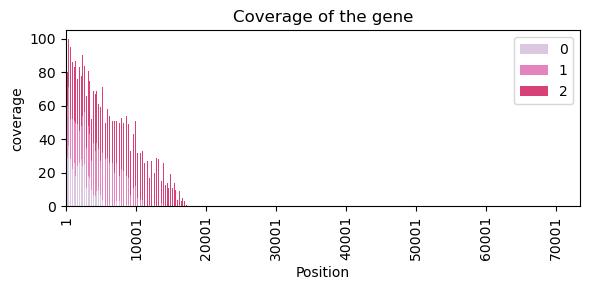

In [18]:
plot_df = df[[0,1,2, 'coord']].copy()
plot_df.set_index('coord', inplace=True)
# get only every 10 rows to make the plot more readable
plot_df = plot_df.iloc[::100]
figsize=(6,3)
num_categories = 3
cmap = sns.color_palette('PuRd', n_colors=num_categories)
colors = [cmap[i] for i in range(num_categories)]
fig, ax = plt.subplots(figsize=figsize)
plot_df.plot(kind='bar', stacked=True, color=colors, ax=ax, alpha = 0.8)
xmax = plot_df.index[-1]
print(xmax)
# Set xticks to correspond to each entry in the downsampled DataFrame
step = 100
ax.set_xticks(range(0, len(plot_df), step))
ax.set_xticklabels(plot_df.index[::step], rotation=90)

# write only the xticks that are multiples of 1000
ax.set_xlabel('Position')
ax.set_ylabel('coverage')
ax.set_title('Coverage of the gene')
plt.tight_layout()
plt.show()

In [4]:
def transform_jesse_gtf_df(df):
    df = df[['nucleotide_coord', 'rate_for_this_nt']].copy()
    # Step 1: Rename the columns
    df = df.rename(columns={'nucleotide_coord': 'end', 'rate_for_this_nt': 'true_h'})
    # Step 2: Create a start column
    df['start'] = df['end'] - 1
    df['diff'] = df['true_h'].diff()
    df['diff'] = df['diff'].fillna(0)
    df['group'] = (df['diff'] != 0).cumsum()
    output_df = df.groupby('group').agg({'start': 'first', 'end': 'last', 'true_h': 'first'}).reset_index(drop=True)
    output_df['length'] = output_df['end'] - output_df['start']
    output_df['feature'] = 'gene'
    return output_df

gtf_fn = '/gladstone/engelhardt/lab/hvu/RNA_rates/data_from_jesse/ENSG00000003989/ENSG00000003989_ENST00000494857_RegionSizeRange_5000-5000_ElongationRateRange_500-5000_PauseRate_1_PauseChance_0.0_ntRatesandTraversalTimes.gtf'
gtf_df = pd.read_csv(gtf_fn, header = 0, index_col = None, sep = '\t')
clean_gtf_df = transform_jesse_gtf_df(gtf_df)

In [6]:
coverage_df = df[['coord',0,1,2]].copy()
coverage_df.rename({'coord': 'position'}, axis=1, inplace=True)
import importlib
importlib.reload(estElong)
elong_estimator = estElong(coverage_df, clean_gtf_df, h_bin_bp=[100, 500, 1000, 2000], output_folder='/gladstone/engelhardt/lab/hvu/RNA_rates/data_from_jesse/ENSG00000003989')
elong_estimator.estimate()

ImportError: module estElong not in sys.modules

In [21]:
def draw_regression_lines(elong_estimator, save_fn=None, show=True):
    '''
    Draw the regression lines on top of the coverage data
    :param save_fn:
    :return:
    '''
    elong_estimator.recover_full_coverage()  # create elong_estimator.full_coverage_df from elong_estimator.coverage_df
    elong_estimator.coverage_df = elong_estimator.coverage_df.loc[ elong_estimator.full_coverage_df.index]
    elong_estimator.pwlr_from_full_coverage(recalculate=False)  # for each time point from startT_idx to endT_idx, do the piecewise linear regression
    # dictionary with keys: time points, values: pwlr_model objects that has been trained on the data of culmulative coverage
    # for each pwlr_model, we can get access to the regression breakpoints through pwlr_model.px and pwlr_model.py
    plotGap_n = 10
    plot_df = elong_estimator.coverage_df.loc[::plotGap_n]  # we do not need to plot every datapoints
    num_timepoints = len(elong_estimator.pwlr_dict.keys())
    cmap = sns.color_palette('Blues', n_colors=num_timepoints)
    colors = [cmap[i] for i in range(num_timepoints)]
    fig, ax = plt.subplots(figsize=(10, 5))
    width = 0.85* find_gap(plot_df['position'])  # the width of the bars should never exceed the numerical distance between each of the x-axis value
    for time_idx in range(3):  # we want to plot the regression lines for the endT_idx as well
        bottom = np.zeros(len(plot_df['position']))
        if time_idx > 0:
            bottom = elong_estimator.full_coverage_df.loc[::plotGap_n][time_idx-1].values
        ax.bar(plot_df['position'], plot_df[time_idx], color=colors[time_idx], bottom = bottom, alpha=0.8, label=time_idx, width=width, linewidth=0)
        pwlr_model = elong_estimator.pwlr_dict[time_idx]
        px, py = pwlr_model.px.detach().numpy(), pwlr_model.py.detach().numpy()
        ax.plot(px, py, '-or')  # red
    # ax.set_xlim(0, elong_estimator.full_coverage_df['position'].max())
    # ax.set_ylim(0, elong_estimator.full_coverage_df.max().max())
    ax.legend()
    if save_fn is not None:
        helper.create_folder_for_file(save_fn)
        plt.savefig(save_fn)
    if show:
        plt.show()
    return


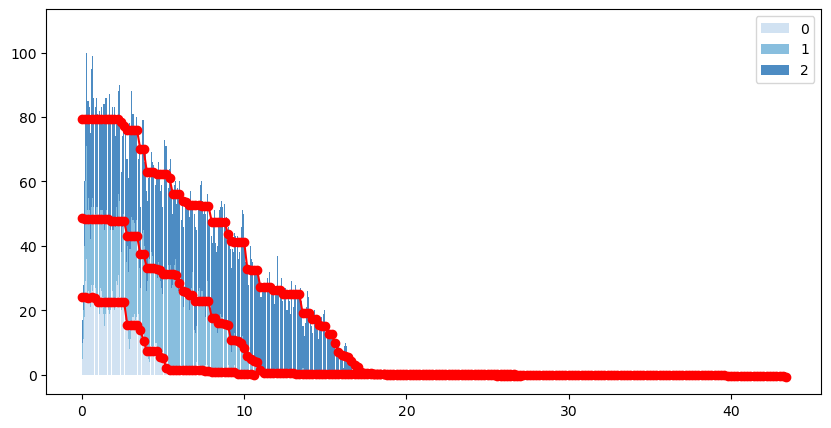

In [38]:
draw_regression_lines(elong_estimator, save_fn='/gladstone/engelhardt/lab/hvu/RNA_rates/data_from_jesse/ENSG00000003989/ENSG00000003989_regression_lines.png')

In [39]:
import torch
from solver_Ahb.train_loop import SimpleSolver, BayesianNormalSolver, BayesianRBFSolver, BayesianLogNormalSolver, SimpleSmoothSolver
from torch.utils.data import Dataset, DataLoader
# Example custom dataset
class CustomData(Dataset):
    def __init__(self, A, b):
        """
        Args:
            data (Tensor): Input data, e.g., features.
            targets (Tensor): Target data, e.g., labels.
        """
        self.data = torch.tensor(A).float()
        self.targets = torch.tensor(b).float()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_point = self.data[idx]
        target = self.targets[idx]
        return data_point, target

    def avg_pred_h(self):
        '''
        Given A and b, calculate the average pred_h across all samples
        :return:
        '''
        dist_traveled = torch.sum(self.data, dim = 1)
        pred_h = dist_traveled / self.targets
        return pred_h.mean(dim=0)

def run_one_method(d, method, breaks, true_h, dataloader, lambda_smooth = 1):
    nan_tensor = torch.tensor([np.nan]*d).cpu().numpy()
    if method == 'simpleSolver':
        Ssolver = SimpleSolver(d, init_h=true_h, dataloader=dataloader)  # solve for h such that A/h = b
        try:
            simple_h = Ssolver.solve()
            return simple_h.cpu().numpy()
        except:
            return nan_tensor
    if method == 'simpleSmooth':
        SSS = SimpleSmoothSolver(d, init_h=true_h, dataloader=dataloader, lambda_smooth = lambda_smooth)  # solve for h such that A/h = b, with some smoothness constraint
        try:
            avg_h = dataloader.dataset.avg_pred_h()
            simple_smooth_h = SSS.solve(avg_h=avg_h)
            return simple_smooth_h.cpu().numpy()
        except:
            return nan_tensor
    elif method == 'bayesLinearSolver':
        BNSolver = BayesianNormalSolver(d, init_h=true_h, dataloader=dataloader)  # solve for h such that A/h = b, with some prior distribution for h set by the solver
        try:
            bayes_linear_h = BNSolver.solve()
            return bayes_linear_h.cpu().numpy()
        except:
            return nan_tensor
    elif method == 'bayesRBFSolver':
        if len(breaks) == 2:  # the h_bin is too big compared to the length of the gene
            return nan_tensor
        assert (breaks[1] - breaks[0]) > 0 and (breaks[1] - breaks[0]) < torch.inf, 'The binsize for the elongation rates calculation should be positive and less than infirity'
        h_bins = breaks[1] - breaks[0]
        B_RBFSolver = BayesianRBFSolver(d, init_h=true_h, dataloader=dataloader, coords=breaks[:-1] + h_bins * 0.5)
        try:
            bayes_RBF_h = B_RBFSolver.solve()
            return bayes_RBF_h.cpu().numpy()
        except:
            return nan_tensor
    elif method == 'logNormalSolver':
        logNormalSolver = BayesianLogNormalSolver(d, init_h=true_h, dataloader=dataloader)
        try:
            logNormal_h = logNormalSolver.solve()
            return logNormal_h.cpu().numpy()
        except:
            return nan_tensor
    else:
        return nan_tensor
    

In [45]:
breaks = elong_estimator.h_breaks_list[0]
breaks = np.arange(0, 70, 1)
breaks = np.append(breaks, np.inf)
print(breaks)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. inf]


In [46]:
A = elong_estimator.findA(elong_estimator.x0, elong_estimator.x1, breaks)
n = len(elong_estimator.x0)
b = np.ones(n)* 5
dataset = CustomData(A, b)
batch_size = 2048
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
d = A.shape[1]
result_df= pd.DataFrame()
result_df['start'] = breaks[:-1]
result_df['end'] = breaks[1:]
result_df['simpleSmooth'] = run_one_method(d, 'simpleSmooth', breaks, 1.18, dataloader, lambda_smooth=0.1)

Epoch [1/1000], Average Loss: 0.7519, Learning Rate: 0.010000
Epoch [501/1000], Average Loss: 0.0943, Learning Rate: 0.010000


In [47]:
result_df

,start,end,simpleSmooth
0,0.0,1.0,1.688563
1,1.0,2.0,2.211606
2,2.0,3.0,2.004583
3,3.0,4.0,1.215809
4,4.0,5.0,1.384484
...,...,...,...
65,65.0,66.0,1.092679
66,66.0,67.0,1.092679
67,67.0,68.0,1.092679
68,68.0,69.0,1.092680


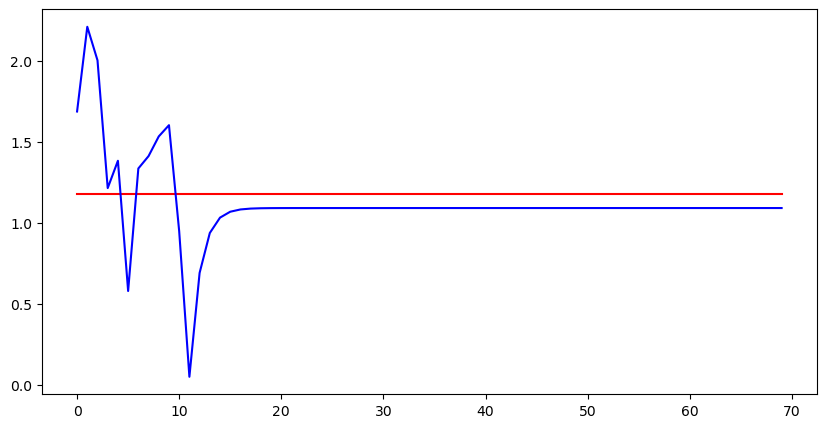

In [48]:
# draw the prediction of the elongation rate and the true elongation rate
# x_axis: length along the gene
# y_axis: elongation rate
# color: different methods and true elongation rate
fig, ax = plt.subplots(figsize=(10, 5))
result_df['true_h'] = 1.18
result_df['simpleSmooth'] = result_df['simpleSmooth'].fillna(0)
ax.plot(result_df['start'], result_df['true_h'], label='true_h', color='red')
ax.plot(result_df['start'], result_df['simpleSmooth'], label='simpleSmooth', color='blue')